In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import model.sdes as sdes
import model.generate as generate
import model.image_unet as image_unet
import model.util as model_util
import analysis.fid as fid
from plot.plot import plot_mnist_digits
import torch
import torchvision
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import os
import time

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

In [3]:
# TODO: this is currently rather inefficient; a decision-tree-style structure
# would be better

def class_time_to_branch(c, t, branch_defs):
    """
    Given a class and a time (both scalars), return the
    corresponding branch index.
    """
    for i, branch_def in enumerate(branch_defs):
        if c in branch_def[0] and t >= branch_def[1] and t <= branch_def[2]:
            return i
    raise ValueError("Undefined class and time")
        
def class_time_to_branch_tensor(c, t, branch_defs):
    """
    Given tensors of classes and a times, return the
    corresponding branch indices as a tensor.
    """
    return torch.tensor([
        class_time_to_branch(c_i, t_i, branch_defs) for c_i, t_i in zip(c, t)
    ], device=DEVICE)

def class_to_class_index_tensor(c, classes):
    """
    Given a tensor of classes, return the corresponding class indices
    as a tensor.
    """
    return torch.argmax(
        (c[:, None] == torch.tensor(classes, device=c.device)).int(), dim=1
    ).to(DEVICE)

In [4]:
models_base_path = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/"

# os.environ["MODEL_DIR"] = os.path.join(models_base_path, "mnist_continuous_class_extension")
os.environ["MODEL_DIR"] = "/gstore/scratch/u/tsenga5/branched_diffusion/models/trained_models/mnist_extension"

import model.train_continuous_model as train_continuous_model  # Import this AFTER setting environment

In [5]:
# Define the branches
classes = list(range(10))
branch_defs = [((0, 1, 2, 3, 4, 5, 6, 7, 8, 9), 0.4854854854854855, 1), ((1, 2, 3, 4, 5, 6, 7, 8, 9), 0.44744744744744747, 0.4854854854854855), ((2, 3, 4, 5, 6, 7, 8, 9), 0.43343343343343343, 0.44744744744744747), ((2, 3, 4, 5, 7, 8, 9), 0.4164164164164164, 0.43343343343343343), ((3, 4, 5, 7, 8, 9), 0.3743743743743744, 0.4164164164164164), ((3, 4, 5, 8, 9), 0.3683683683683684, 0.3743743743743744), ((3, 4, 5, 9), 0.35235235235235235, 0.3683683683683684), ((3, 4, 5), 0.3483483483483483, 0.35235235235235235), ((3, 5), 0.27127127127127126, 0.3483483483483483), ((0,), 0, 0.4854854854854855), ((1,), 0, 0.44744744744744747), ((6,), 0, 0.43343343343343343), ((2,), 0, 0.4164164164164164), ((7,), 0, 0.3743743743743744), ((8,), 0, 0.3683683683683684), ((9,), 0, 0.35235235235235235), ((4,), 0, 0.3483483483483483), ((5,), 0, 0.27127127127127126), ((3,), 0, 0.27127127127127126)]

input_shape = (1, 28, 28)

In [6]:
# Define the SDE
sde = sdes.VariancePreservingSDE(0.1, 20, input_shape)
t_limit = 1

### Introducing a new digit class

In [7]:
# Define the branches
classes_049 = [0, 4, 9]
branch_defs_049 = [
    ((0, 4, 9), 0.5, 1),
    ((0,), 0, 0.5),
    ((4, 9), 0.35, 0.5),
    ((4,), 0, 0.35),
    ((9,), 0, 0.35)
]

classes_0497 = [0, 4, 9, 7]
branch_defs_0497 = [
    ((0, 4, 7, 9), 0.5, 1),
    ((0,), 0, 0.5),
    ((4, 7, 9), 0.38, 0.5),
    ((7,), 0, 0.38),
    ((4, 9), 0.35, 0.38),
    ((4,), 0, 0.35),
    ((9,), 0, 0.35)
]

classes_7 = [7]
branch_defs_7 = [
    ((7,), 0, 0.38)
]

branch_defs_049_linear = [
    ((0, 4, 9), 0, 1)
]

branch_defs_0497_linear = [
    ((0, 4, 7, 9), 0, 1)
]

# Define the SDE and data loaders
sde = sdes.VariancePreservingSDE(0.1, 20, input_shape)

t_limit = 1

dataset_049 = torchvision.datasets.MNIST(
    "/gstore/data/resbioai/tsenga5/datasets", train=True, transform=(lambda img: (np.asarray(img)[None] / 256 * 2) - 1)
)
dataset_0497 = torchvision.datasets.MNIST(
    "/gstore/data/resbioai/tsenga5/datasets", train=True, transform=(lambda img: (np.asarray(img)[None] / 256 * 2) - 1)
)
dataset_7 = torchvision.datasets.MNIST(
    "/gstore/data/resbioai/tsenga5/datasets", train=True, transform=(lambda img: (np.asarray(img)[None] / 256 * 2) - 1)
)

# Limit classes
inds_049 = np.isin(dataset_049.targets, classes_049)
dataset_049.data = dataset_049.data[inds_049]
dataset_049.targets = dataset_049.targets[inds_049]
inds_0497 = np.isin(dataset_0497.targets, classes_0497)
dataset_0497.data = dataset_0497.data[inds_0497]
dataset_0497.targets = dataset_0497.targets[inds_0497]
inds_7 = np.isin(dataset_7.targets, classes_7)
dataset_7.data = dataset_7.data[inds_7]
dataset_7.targets = dataset_7.targets[inds_7]

data_loader_049 = torch.utils.data.DataLoader(dataset_049, batch_size=128, shuffle=True, num_workers=2)
data_loader_0497 = torch.utils.data.DataLoader(dataset_0497, batch_size=128, shuffle=True, num_workers=2)
data_loader_7 = torch.utils.data.DataLoader(dataset_7, batch_size=128, shuffle=True, num_workers=2)
input_shape = next(iter(data_loader_049))[0].shape[1:]

#### Train extra branch on branched model

In [8]:
def map_branch_def(branch_def, target_branch_defs):
    """
    Given a particular branch definition (i.e. a triplet), and a
    list of branch definitions, attempts to match that branch
    definition to the corresponding entry in the list. This
    mapping is based on whether or not the branch would need to be
    retrained. The query `branch_def` is matched to a target within
    `branch_defs` if the target's class indices are all present in
    the query, and the query time is a sub-interval of the target
    time.
    Arguments:
        `branch_def`: a branch definition (i.e. triplet of class index
            tuple, start time, and end time)
        `target_branch_defs`: a list of branch definitions
    Returns the index of the matched branch definition in `branch_defs`,
    or -1 if there is no suitable match found.
    """
    for i, target_branch_def in enumerate(target_branch_defs):
        if set(branch_def[0]).issuperset(set(target_branch_def[0])) \
            and branch_def[1] >= target_branch_def[1] \
            and branch_def[2] <= target_branch_def[2]:
            return i
    return -1

In [9]:
branched_model_1 = model_util.load_model(
    image_unet.MultitaskMNISTUNetTimeConcat,
    # os.path.join(models_base_path, "mnist_continuous_049/2/epoch_30_ckpt.pth")
    os.path.join(models_base_path, "mnist_continuous_class_extension/mnist_continuous_branched_3classes/1/last_ckpt.pth")
).to(DEVICE)

Sampling class: 0


100%|████████████████████████████████████████████████████████| 500/500 [00:19<00:00, 25.06it/s]


Sampling class: 4


100%|████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 26.89it/s]


Sampling class: 9


100%|████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 27.55it/s]


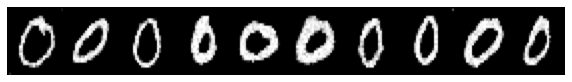

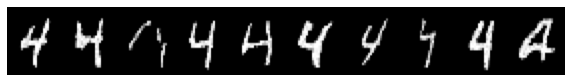

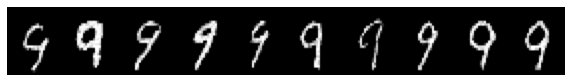

In [10]:
# Generate the samples
branched_samples_before = {}
for class_to_sample in classes_049:
    print("Sampling class: %s" % class_to_sample)
    samples = generate.generate_continuous_branched_samples(
        branched_model_1, sde, class_to_sample,
        lambda c, t: class_time_to_branch_tensor(c, t, branch_defs_049),
        sampler="pc", t_limit=t_limit, num_samples=1000, verbose=True
    ).cpu().numpy()
    plot_mnist_digits(samples, grid_size=(10, 1), title=None)
    branched_samples_before[class_to_sample] = samples

In [11]:
# Create new model and copy over parameters
branched_model_2 = image_unet.MultitaskMNISTUNetTimeConcat(
    len(branch_defs_0497), t_limit=t_limit
).to(DEVICE)

# Figure out which branches should be copied over to which ones
branch_map_inds = [
    map_branch_def(bd, branch_defs_049) for bd in branch_defs_0497
]

# For each submodule, copy over the weights
# Careful: this assumes a particular kind of architecture!
for module_name, module_list in branched_model_1.named_children():
    if len(module_list) == 1:
        branched_model_2.get_submodule(module_name).load_state_dict(
            module_list.state_dict()
        )
    elif len(module_list) == len(branch_defs_049):
        target_module_list = branched_model_2.get_submodule(module_name)
        for target_i, source_i in enumerate(branch_map_inds):
            if source_i != -1:
                target_module_list[target_i].load_state_dict(
                    module_list[source_i].state_dict()
                )
            else:
                # Copy over some other branch for a warm start
                # We'll manually set it for now (TODO)
                source_i = -1  # Last branch
                target_module_list[target_i].load_state_dict(
                    module_list[source_i].state_dict()
                )
    else:
        raise ValueError("Found module list of length %d" % len(module_list))

Sampling class: 0


100%|███████████████████████████████████████████████████████| 500/500 [00:03<00:00, 131.25it/s]


Sampling class: 4


100%|███████████████████████████████████████████████████████| 500/500 [00:04<00:00, 122.79it/s]


Sampling class: 9


100%|███████████████████████████████████████████████████████| 500/500 [00:04<00:00, 119.96it/s]


Sampling class: 7


100%|███████████████████████████████████████████████████████| 500/500 [00:02<00:00, 173.30it/s]


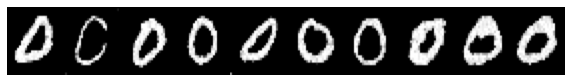

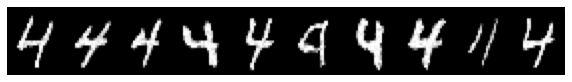

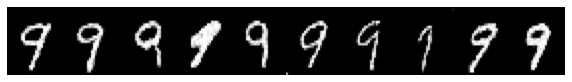

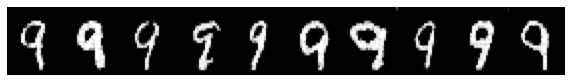

In [12]:
# Generate the digits to double check the match-up was done correctly
for class_to_sample in classes_0497:
    print("Sampling class: %s" % class_to_sample)
    samples = generate.generate_continuous_branched_samples(
        branched_model_2, sde, class_to_sample,
        lambda c, t: class_time_to_branch_tensor(c, t, branch_defs_0497),
        sampler="pc", t_limit=t_limit, verbose=True
    ).cpu().numpy()
    plot_mnist_digits(samples, grid_size=(10, 1), title=None)

In [13]:
# Train the model, for the specific branches only

# Freeze all shared layers of the model, and freeze all task-specific
# layers other than the ones we want to train
for module_name, module_list in branched_model_2.named_children():
    if len(module_list) == 1:
        for p in module_list[0].parameters():
            p.requires_grad = False
    elif len(module_list) == len(branch_defs_0497):
        for i in range(len(module_list)):
            if branch_map_inds[i] != -1:
                for p in module_list[i].parameters():
                    p.requires_grad = False
            else:
                for p in module_list[i].parameters():
                    p.requires_grad = True
    else:
        raise ValueError("Found module list of length %d" % len(module_list))

# Train
train_continuous_model.train_ex.run(
    "train_branched_model",
    config_updates={
        "model": branched_model_2,
        "sde": sde,
        "data_loader": data_loader_7,
        "class_time_to_branch_index": lambda c, t: class_time_to_branch_tensor(c, t, branch_defs_0497),
        "num_epochs": 50,
        "learning_rate": 0.001,
        "t_limit": branch_defs_7[0][2],
        "loss_weighting_type": "empirical_norm"
    }
)

WARNING - root - Added new config entry: "class_time_to_branch_index"
WARNING - root - Added new config entry: "data_loader"
WARNING - root - Added new config entry: "loss_weighting_type"
WARNING - root - Added new config entry: "model"
WARNING - root - Added new config entry: "sde"
WARNING - root - Added new config entry: "t_limit"
INFO - train - Running command 'train_branched_model'
INFO - train - Started run with ID "8"
Loss: 55.82: 100%|█████████████████████████████████████████████| 49/49 [00:06<00:00,  7.54it/s]


Epoch 1 average Loss: 59.34


Loss: 50.18: 100%|█████████████████████████████████████████████| 49/49 [00:03<00:00, 15.49it/s]


Epoch 2 average Loss: 54.65


Loss: 51.57: 100%|█████████████████████████████████████████████| 49/49 [00:07<00:00,  6.94it/s]


Epoch 3 average Loss: 54.04


Loss: 61.65: 100%|█████████████████████████████████████████████| 49/49 [00:05<00:00,  8.72it/s]


Epoch 4 average Loss: 55.29


Loss: 50.59: 100%|█████████████████████████████████████████████| 49/49 [00:04<00:00, 10.64it/s]


Epoch 5 average Loss: 53.50


Loss: 45.16: 100%|█████████████████████████████████████████████| 49/49 [00:07<00:00,  6.73it/s]


Epoch 6 average Loss: 53.83


Loss: 45.15: 100%|█████████████████████████████████████████████| 49/49 [00:03<00:00, 14.74it/s]


Epoch 7 average Loss: 53.55


Loss: 53.54: 100%|█████████████████████████████████████████████| 49/49 [00:23<00:00,  2.13it/s]


Epoch 8 average Loss: 53.67


Loss: 44.40: 100%|█████████████████████████████████████████████| 49/49 [00:36<00:00,  1.35it/s]


Epoch 9 average Loss: 52.30


Loss: 52.57: 100%|█████████████████████████████████████████████| 49/49 [00:34<00:00,  1.44it/s]


Epoch 10 average Loss: 52.46


Loss: 54.75: 100%|█████████████████████████████████████████████| 49/49 [00:29<00:00,  1.66it/s]


Epoch 11 average Loss: 53.20


Loss: 53.38: 100%|█████████████████████████████████████████████| 49/49 [00:26<00:00,  1.85it/s]


Epoch 12 average Loss: 53.09


Loss: 57.27: 100%|█████████████████████████████████████████████| 49/49 [00:04<00:00, 11.09it/s]


Epoch 13 average Loss: 53.26


Loss: 54.48: 100%|█████████████████████████████████████████████| 49/49 [00:02<00:00, 16.85it/s]


Epoch 14 average Loss: 51.67


Loss: 49.65: 100%|█████████████████████████████████████████████| 49/49 [00:02<00:00, 17.04it/s]


Epoch 15 average Loss: 51.05


Loss: 56.23: 100%|█████████████████████████████████████████████| 49/49 [00:02<00:00, 16.77it/s]


Epoch 16 average Loss: 52.92


Loss: 57.27: 100%|█████████████████████████████████████████████| 49/49 [00:03<00:00, 15.49it/s]


Epoch 17 average Loss: 50.74


Loss: 51.19: 100%|█████████████████████████████████████████████| 49/49 [00:03<00:00, 15.79it/s]


Epoch 18 average Loss: 51.66


Loss: 50.47: 100%|█████████████████████████████████████████████| 49/49 [00:03<00:00, 14.56it/s]


Epoch 19 average Loss: 52.55


Loss: 64.75: 100%|█████████████████████████████████████████████| 49/49 [00:36<00:00,  1.35it/s]


Epoch 20 average Loss: 53.86


Loss: 50.11: 100%|█████████████████████████████████████████████| 49/49 [00:32<00:00,  1.49it/s]


Epoch 21 average Loss: 49.93


Loss: 55.43: 100%|█████████████████████████████████████████████| 49/49 [00:13<00:00,  3.60it/s]


Epoch 22 average Loss: 50.91


Loss: 49.15: 100%|█████████████████████████████████████████████| 49/49 [00:05<00:00,  8.71it/s]


Epoch 23 average Loss: 50.88


Loss: 48.22: 100%|█████████████████████████████████████████████| 49/49 [00:35<00:00,  1.39it/s]


Epoch 24 average Loss: 50.64


Loss: 41.08: 100%|█████████████████████████████████████████████| 49/49 [00:34<00:00,  1.44it/s]


Epoch 25 average Loss: 50.32


Loss: 63.01: 100%|█████████████████████████████████████████████| 49/49 [00:11<00:00,  4.39it/s]


Epoch 26 average Loss: 51.71


Loss: 60.30: 100%|█████████████████████████████████████████████| 49/49 [00:03<00:00, 14.24it/s]


Epoch 27 average Loss: 51.09


Loss: 54.70: 100%|█████████████████████████████████████████████| 49/49 [00:03<00:00, 16.05it/s]


Epoch 28 average Loss: 50.91


Loss: 48.52: 100%|█████████████████████████████████████████████| 49/49 [00:03<00:00, 16.09it/s]


Epoch 29 average Loss: 51.46


Loss: 49.58: 100%|█████████████████████████████████████████████| 49/49 [00:03<00:00, 14.67it/s]


Epoch 30 average Loss: 51.39


Loss: 44.48: 100%|█████████████████████████████████████████████| 49/49 [00:03<00:00, 15.61it/s]


Epoch 31 average Loss: 52.51


Loss: 53.77: 100%|█████████████████████████████████████████████| 49/49 [00:03<00:00, 15.55it/s]


Epoch 32 average Loss: 49.86


Loss: 41.41: 100%|█████████████████████████████████████████████| 49/49 [00:03<00:00, 14.97it/s]


Epoch 33 average Loss: 50.84


Loss: 53.35: 100%|█████████████████████████████████████████████| 49/49 [00:03<00:00, 14.50it/s]


Epoch 34 average Loss: 51.01


Loss: 55.85: 100%|█████████████████████████████████████████████| 49/49 [00:02<00:00, 16.60it/s]


Epoch 35 average Loss: 50.45


Loss: 54.15: 100%|█████████████████████████████████████████████| 49/49 [00:03<00:00, 15.44it/s]


Epoch 36 average Loss: 51.61


Loss: 49.87: 100%|█████████████████████████████████████████████| 49/49 [00:03<00:00, 12.79it/s]


Epoch 37 average Loss: 51.58


Loss: 49.26: 100%|█████████████████████████████████████████████| 49/49 [00:07<00:00,  6.82it/s]


Epoch 38 average Loss: 51.94


Loss: 41.97: 100%|█████████████████████████████████████████████| 49/49 [00:04<00:00, 11.04it/s]


Epoch 39 average Loss: 50.27


Loss: 46.20: 100%|█████████████████████████████████████████████| 49/49 [00:05<00:00,  9.04it/s]


Epoch 40 average Loss: 50.89


Loss: 50.28: 100%|█████████████████████████████████████████████| 49/49 [00:07<00:00,  6.81it/s]


Epoch 41 average Loss: 49.68


Loss: 50.56: 100%|█████████████████████████████████████████████| 49/49 [00:03<00:00, 14.96it/s]


Epoch 42 average Loss: 50.70


Loss: 55.76: 100%|█████████████████████████████████████████████| 49/49 [00:03<00:00, 14.56it/s]


Epoch 43 average Loss: 50.57


Loss: 49.05: 100%|█████████████████████████████████████████████| 49/49 [00:07<00:00,  6.82it/s]


Epoch 44 average Loss: 49.80


Loss: 48.83: 100%|█████████████████████████████████████████████| 49/49 [00:05<00:00,  9.73it/s]


Epoch 45 average Loss: 50.40


Loss: 50.82: 100%|█████████████████████████████████████████████| 49/49 [00:04<00:00, 10.23it/s]


Epoch 46 average Loss: 49.80


Loss: 51.91: 100%|█████████████████████████████████████████████| 49/49 [00:07<00:00,  6.91it/s]


Epoch 47 average Loss: 51.90


Loss: 52.48: 100%|█████████████████████████████████████████████| 49/49 [00:04<00:00, 12.21it/s]


Epoch 48 average Loss: 50.27


Loss: 55.94: 100%|█████████████████████████████████████████████| 49/49 [00:05<00:00,  8.96it/s]


Epoch 49 average Loss: 50.79


Loss: 48.51: 100%|█████████████████████████████████████████████| 49/49 [00:07<00:00,  6.83it/s]
INFO - train - Completed after 0:08:10


Epoch 50 average Loss: 49.87


Sampling class: 0


100%|████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 27.66it/s]


Sampling class: 4


100%|████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 26.57it/s]


Sampling class: 9


100%|████████████████████████████████████████████████████████| 500/500 [00:19<00:00, 26.11it/s]


Sampling class: 7


100%|████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 26.47it/s]


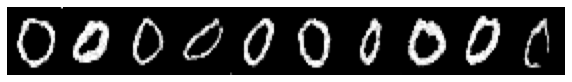

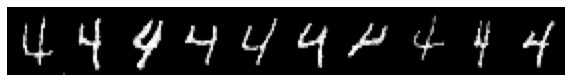

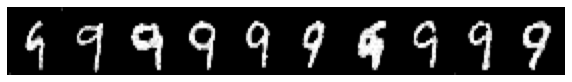

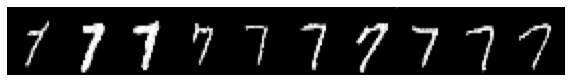

In [14]:
# Generate the digits
branched_samples_after = {}
for class_to_sample in classes_0497:
    print("Sampling class: %s" % class_to_sample)
    samples = generate.generate_continuous_branched_samples(
        branched_model_2, sde, class_to_sample,
        lambda c, t: class_time_to_branch_tensor(c, t, branch_defs_0497),
        sampler="pc", t_limit=t_limit, num_samples=1000, verbose=True
    ).cpu().numpy()
    branched_samples_after[class_to_sample] = samples
    plot_mnist_digits(samples, grid_size=(10, 1), title=None)

#### Train label-guided model with only new class

In [15]:
# Import the label-guided model again
label_guided_model_1 = model_util.load_model(
    image_unet.LabelGuidedMNISTUNetTimeConcat,
    os.path.join(models_base_path, "mnist_continuous_class_extension/mnist_continuous_labelguided_3classes/3/last_ckpt.pth")
).to(DEVICE)

Sampling class: 0


100%|████████████████████████████████████████████████████████| 500/500 [00:22<00:00, 22.64it/s]


Sampling class: 4


100%|████████████████████████████████████████████████████████| 500/500 [00:22<00:00, 22.13it/s]


Sampling class: 9


100%|████████████████████████████████████████████████████████| 500/500 [00:22<00:00, 22.10it/s]


Sampling class: 7


100%|████████████████████████████████████████████████████████| 500/500 [00:22<00:00, 22.09it/s]


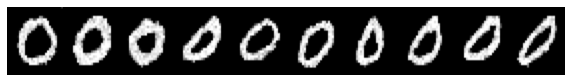

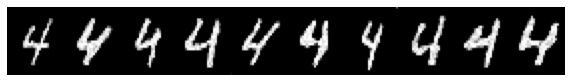

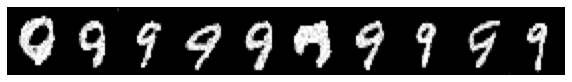

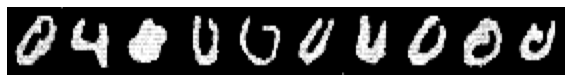

In [16]:
linear_samples_before = {}
for class_to_sample in classes_0497:
    print("Sampling class: %s" % class_to_sample)
    samples = generate.generate_continuous_label_guided_samples(
        label_guided_model_1, sde, class_to_sample,
        lambda c: class_to_class_index_tensor(c, classes_0497),
        sampler="pc", t_limit=t_limit, num_samples=1000, verbose=True
    ).cpu().numpy()
    linear_samples_before[class_to_sample] = samples
    plot_mnist_digits(samples, grid_size=(10, 1), title=None)

In [17]:
# Introduce new digit to label-guided model and train
train_continuous_model.train_ex.run(
    "train_label_guided_model",
    config_updates={
        "model": label_guided_model_1,
        "sde": sde,
        "data_loader": data_loader_7,
        "class_to_class_index": lambda c: class_to_class_index_tensor(c, classes_0497),
        "num_epochs": 10,
        "learning_rate": 0.001,
        "t_limit": t_limit,
        "loss_weighting_type": "empirical_norm"
    }
)

WARNING - root - Added new config entry: "class_to_class_index"
WARNING - root - Added new config entry: "data_loader"
WARNING - root - Added new config entry: "loss_weighting_type"
WARNING - root - Added new config entry: "model"
WARNING - root - Added new config entry: "sde"
WARNING - root - Added new config entry: "t_limit"
INFO - train - Running command 'train_label_guided_model'
INFO - train - Started run with ID "9"
Loss: 28.68: 100%|█████████████████████████████████████████████| 49/49 [00:01<00:00, 27.50it/s]


Epoch 1 average Loss: 51.33


Loss: 32.94: 100%|█████████████████████████████████████████████| 49/49 [00:01<00:00, 31.88it/s]


Epoch 2 average Loss: 30.67


Loss: 27.98: 100%|█████████████████████████████████████████████| 49/49 [00:01<00:00, 25.39it/s]


Epoch 3 average Loss: 28.81


Loss: 22.15: 100%|█████████████████████████████████████████████| 49/49 [00:01<00:00, 28.45it/s]


Epoch 4 average Loss: 27.32


Loss: 26.51: 100%|█████████████████████████████████████████████| 49/49 [00:01<00:00, 25.68it/s]


Epoch 5 average Loss: 28.88


Loss: 47.59: 100%|█████████████████████████████████████████████| 49/49 [00:01<00:00, 27.36it/s]


Epoch 6 average Loss: 27.53


Loss: 24.82: 100%|█████████████████████████████████████████████| 49/49 [00:01<00:00, 28.12it/s]


Epoch 7 average Loss: 28.51


Loss: 27.43: 100%|█████████████████████████████████████████████| 49/49 [00:01<00:00, 31.29it/s]


Epoch 8 average Loss: 27.51


Loss: 30.16: 100%|█████████████████████████████████████████████| 49/49 [00:01<00:00, 28.13it/s]


Epoch 9 average Loss: 28.20


Loss: 33.62: 100%|█████████████████████████████████████████████| 49/49 [00:01<00:00, 25.34it/s]
INFO - train - Completed after 0:00:18


Epoch 10 average Loss: 27.49


Sampling class: 0


100%|████████████████████████████████████████████████████████| 500/500 [00:22<00:00, 22.08it/s]


Sampling class: 4


100%|████████████████████████████████████████████████████████| 500/500 [00:22<00:00, 22.11it/s]


Sampling class: 9


100%|████████████████████████████████████████████████████████| 500/500 [00:22<00:00, 22.72it/s]


Sampling class: 7


100%|████████████████████████████████████████████████████████| 500/500 [00:22<00:00, 22.09it/s]


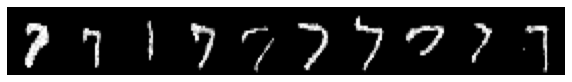

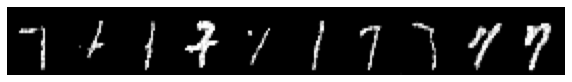

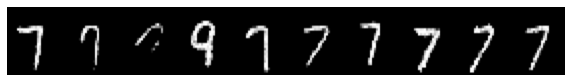

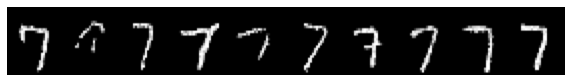

In [18]:
linear_samples_after_newonly = {}
for class_to_sample in classes_0497:
    print("Sampling class: %s" % class_to_sample)
    samples = generate.generate_continuous_label_guided_samples(
        label_guided_model_1, sde, class_to_sample,
        lambda c: class_to_class_index_tensor(c, classes_0497),
        sampler="pc", t_limit=t_limit, num_samples=1000, verbose=True
    ).cpu().numpy()
    plot_mnist_digits(samples, grid_size=(10, 1), title=None)
    linear_samples_after_newonly[class_to_sample] = samples

#### Train label-guided model with all data

In [19]:
# Import the label-guided model again
label_guided_model_2 = model_util.load_model(
    image_unet.LabelGuidedMNISTUNetTimeConcat,
    os.path.join(models_base_path, "mnist_continuous_class_extension/mnist_continuous_labelguided_3classes/3/last_ckpt.pth")
).to(DEVICE)

In [20]:
# Train on all digits
train_continuous_model.train_ex.run(
    "train_label_guided_model",
    config_updates={
        "model": label_guided_model_2,
        "sde": sde,
        "data_loader": data_loader_0497,
        "class_to_class_index": lambda c: class_to_class_index_tensor(c, classes_0497),
        "num_epochs": 30,
        "learning_rate": 0.001,
        "t_limit": t_limit,
        "loss_weighting_type": "empirical_norm"
    }
)

WARNING - root - Added new config entry: "class_to_class_index"
WARNING - root - Added new config entry: "data_loader"
WARNING - root - Added new config entry: "loss_weighting_type"
WARNING - root - Added new config entry: "model"
WARNING - root - Added new config entry: "sde"
WARNING - root - Added new config entry: "t_limit"
INFO - train - Running command 'train_label_guided_model'
INFO - train - Started run with ID "10"
Loss: 20.67: 100%|███████████████████████████████████████████| 188/188 [00:04<00:00, 43.06it/s]


Epoch 1 average Loss: 34.63


Loss: 34.67: 100%|███████████████████████████████████████████| 188/188 [00:04<00:00, 40.47it/s]


Epoch 2 average Loss: 30.14


Loss: 27.53: 100%|███████████████████████████████████████████| 188/188 [00:04<00:00, 38.43it/s]


Epoch 3 average Loss: 29.33


Loss: 30.79: 100%|███████████████████████████████████████████| 188/188 [00:05<00:00, 36.94it/s]


Epoch 4 average Loss: 29.10


Loss: 55.96: 100%|███████████████████████████████████████████| 188/188 [00:04<00:00, 39.15it/s]


Epoch 5 average Loss: 29.99


Loss: 26.96: 100%|███████████████████████████████████████████| 188/188 [00:04<00:00, 41.61it/s]


Epoch 6 average Loss: 30.20


Loss: 30.23: 100%|███████████████████████████████████████████| 188/188 [00:04<00:00, 37.86it/s]


Epoch 7 average Loss: 30.07


Loss: 32.84: 100%|███████████████████████████████████████████| 188/188 [00:04<00:00, 40.94it/s]


Epoch 8 average Loss: 29.93


Loss: 56.76: 100%|███████████████████████████████████████████| 188/188 [00:04<00:00, 39.14it/s]


Epoch 9 average Loss: 30.62


Loss: 25.38: 100%|███████████████████████████████████████████| 188/188 [00:05<00:00, 36.79it/s]


Epoch 10 average Loss: 28.96


Loss: 20.83: 100%|███████████████████████████████████████████| 188/188 [00:04<00:00, 39.67it/s]


Epoch 11 average Loss: 29.44


Loss: 25.18: 100%|███████████████████████████████████████████| 188/188 [00:04<00:00, 38.26it/s]


Epoch 12 average Loss: 29.21


Loss: 28.51: 100%|███████████████████████████████████████████| 188/188 [00:04<00:00, 45.50it/s]


Epoch 13 average Loss: 30.11


Loss: 16.48: 100%|███████████████████████████████████████████| 188/188 [00:04<00:00, 39.38it/s]


Epoch 14 average Loss: 28.56


Loss: 36.06: 100%|███████████████████████████████████████████| 188/188 [00:04<00:00, 40.75it/s]


Epoch 15 average Loss: 29.14


Loss: 31.08: 100%|███████████████████████████████████████████| 188/188 [00:04<00:00, 39.31it/s]


Epoch 16 average Loss: 28.27


Loss: 30.92: 100%|███████████████████████████████████████████| 188/188 [00:04<00:00, 38.78it/s]


Epoch 17 average Loss: 29.01


Loss: 32.28: 100%|███████████████████████████████████████████| 188/188 [00:04<00:00, 40.58it/s]


Epoch 18 average Loss: 29.60


Loss: 16.20: 100%|███████████████████████████████████████████| 188/188 [00:05<00:00, 37.15it/s]


Epoch 19 average Loss: 28.33


Loss: 24.48: 100%|███████████████████████████████████████████| 188/188 [00:03<00:00, 47.52it/s]


Epoch 20 average Loss: 28.93


Loss: 42.57: 100%|███████████████████████████████████████████| 188/188 [00:04<00:00, 37.78it/s]


Epoch 21 average Loss: 28.87


Loss: 36.83: 100%|███████████████████████████████████████████| 188/188 [00:04<00:00, 40.07it/s]


Epoch 22 average Loss: 28.80


Loss: 41.08: 100%|███████████████████████████████████████████| 188/188 [00:04<00:00, 40.83it/s]


Epoch 23 average Loss: 28.78


Loss: 28.57: 100%|███████████████████████████████████████████| 188/188 [00:04<00:00, 38.47it/s]


Epoch 24 average Loss: 29.53


Loss: 22.33: 100%|███████████████████████████████████████████| 188/188 [00:04<00:00, 43.91it/s]


Epoch 25 average Loss: 28.31


Loss: 43.71: 100%|███████████████████████████████████████████| 188/188 [00:05<00:00, 35.65it/s]


Epoch 26 average Loss: 28.44


Loss: 16.64: 100%|███████████████████████████████████████████| 188/188 [00:04<00:00, 43.08it/s]


Epoch 27 average Loss: 28.14


Loss: 26.67: 100%|███████████████████████████████████████████| 188/188 [00:05<00:00, 37.37it/s]


Epoch 28 average Loss: 28.60


Loss: 30.71: 100%|███████████████████████████████████████████| 188/188 [00:04<00:00, 38.22it/s]


Epoch 29 average Loss: 28.18


Loss: 35.19: 100%|███████████████████████████████████████████| 188/188 [00:04<00:00, 39.82it/s]
INFO - train - Completed after 0:02:23


Epoch 30 average Loss: 28.36


Sampling class: 0


100%|████████████████████████████████████████████████████████| 500/500 [00:22<00:00, 22.12it/s]


Sampling class: 4


100%|████████████████████████████████████████████████████████| 500/500 [00:22<00:00, 22.11it/s]


Sampling class: 9


100%|████████████████████████████████████████████████████████| 500/500 [00:22<00:00, 22.13it/s]


Sampling class: 7


100%|████████████████████████████████████████████████████████| 500/500 [00:22<00:00, 22.09it/s]


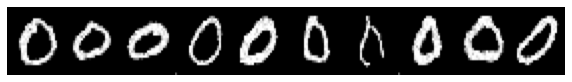

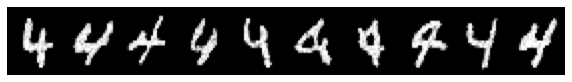

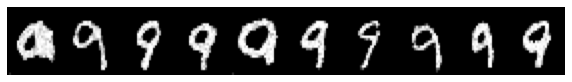

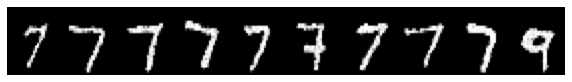

In [22]:
linear_samples_after_all = {}
for class_to_sample in classes_0497:
    print("Sampling class: %s" % class_to_sample)
    samples = generate.generate_continuous_label_guided_samples(
        label_guided_model_2, sde, class_to_sample,
        lambda c: class_to_class_index_tensor(c, classes_0497),
        sampler="pc", t_limit=t_limit, num_samples=1000, verbose=True
    ).cpu().numpy()
    plot_mnist_digits(samples, grid_size=(10, 1), title=None)
    linear_samples_after_all[class_to_sample] = samples

**Compute FIDs**

In [23]:
# Sample digits from the original dataset
true_samples = {}
for class_to_sample in classes_0497:
    print("Sampling class: %s" % class_to_sample)
    inds = np.where(dataset_0497.targets == class_to_sample)[0]
    sample_inds = np.random.choice(inds, size=1000, replace=False)
    samples = ((dataset_0497.data[sample_inds] / 256 * 2) - 1).cpu().numpy()[:, None]
    true_samples[class_to_sample] = samples

Sampling class: 0
Sampling class: 4
Sampling class: 9
Sampling class: 7


In [24]:
branched_before_fids = {}
branched_after_fids = {}
linear_before_fids = {}
linear_after_newonly_fids = {}
linear_after_all_fids = {}

for c in branched_samples_before.keys():
    branched_before_fids[c] = fid.compute_fid(branched_samples_before[c], true_samples[c])
for c in branched_samples_after.keys():
    branched_after_fids[c] = fid.compute_fid(branched_samples_after[c], true_samples[c])
for c in linear_samples_before.keys():
    linear_before_fids[c] = fid.compute_fid(linear_samples_before[c], true_samples[c])
for c in linear_samples_after_newonly.keys():
    linear_after_newonly_fids[c] = fid.compute_fid(linear_samples_after_newonly[c], true_samples[c])
for c in linear_samples_after_all.keys():
    linear_after_all_fids[c] = fid.compute_fid(linear_samples_after_all[c], true_samples[c])

In [25]:
print(branched_before_fids)
print(branched_after_fids)
print(linear_before_fids)
print(linear_after_newonly_fids)
print(linear_after_all_fids)

{0: 23.11633549064858, 4: 17.554127554182706, 9: 19.168488612087437}
{0: 26.994116150415692, 4: 18.230416480830353, 9: 20.033732091018226, 7: 22.96911094572033}
{0: 40.60493446096415, 4: 40.21296005710471, 9: 46.26767416821082, 7: 295.82348278085703}
{0: 224.12945034383986, 4: 104.85626479406496, 9: 99.43909776120395, 7: 29.853624615418624}
{0: 50.39232930384999, 4: 37.86158194936105, 9: 32.856277798307495, 7: 21.466374130747468}
